In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf


from sklearn import preprocessing, model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification

from tensorflow.keras.layers import Flatten, Dense, Conv1D, MaxPool1D, Dropout
from tensorflow.keras.models import Sequential

/home/renan/Área de Trabalho/research-project/py37/lib/python3.7/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
2022-07-22 08:30:21.215003: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-22 08:30:21.215037: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Feature Selection

In [2]:
base_df = pd.read_csv('../workdata/shura/experiment3/results.csv')
base_df.groupby(['diagnostic', 'db']).size()

diagnostic  db                  
AF          WFDB_CPSC2018            356
            WFDB_CPSC2018_2           47
            WFDB_ChapmanShaoxing     406
            WFDB_Ga                  179
            WFDB_PTB                   4
            WFDB_PTBXL               440
            WFDB_StPetersburg          1
SR          WFDB_CPSC2018            291
            WFDB_ChapmanShaoxing     428
            WFDB_Ga                  535
            WFDB_Ningbo             1792
            WFDB_PTB                  25
            WFDB_PTBXL              5390
dtype: int64

     Specs         Score
0     iter  4.701409e+03
1  relstep  1.623656e-01
2  relfval  5.237602e-10
3    delta  1.766011e+02
4      rho  1.079880e+00
5   relerr  1.456821e+00


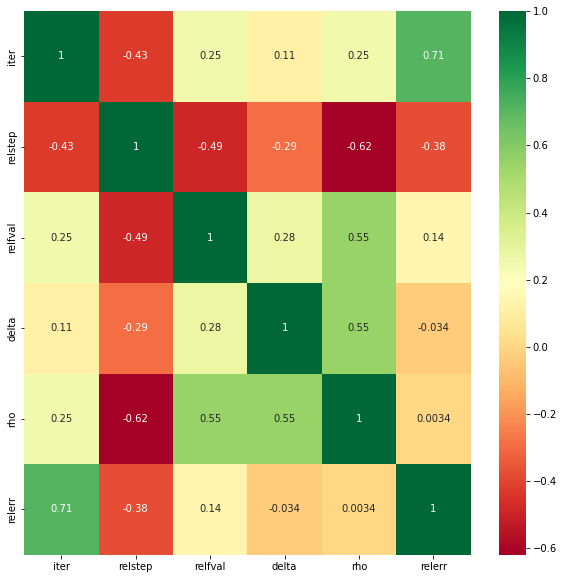

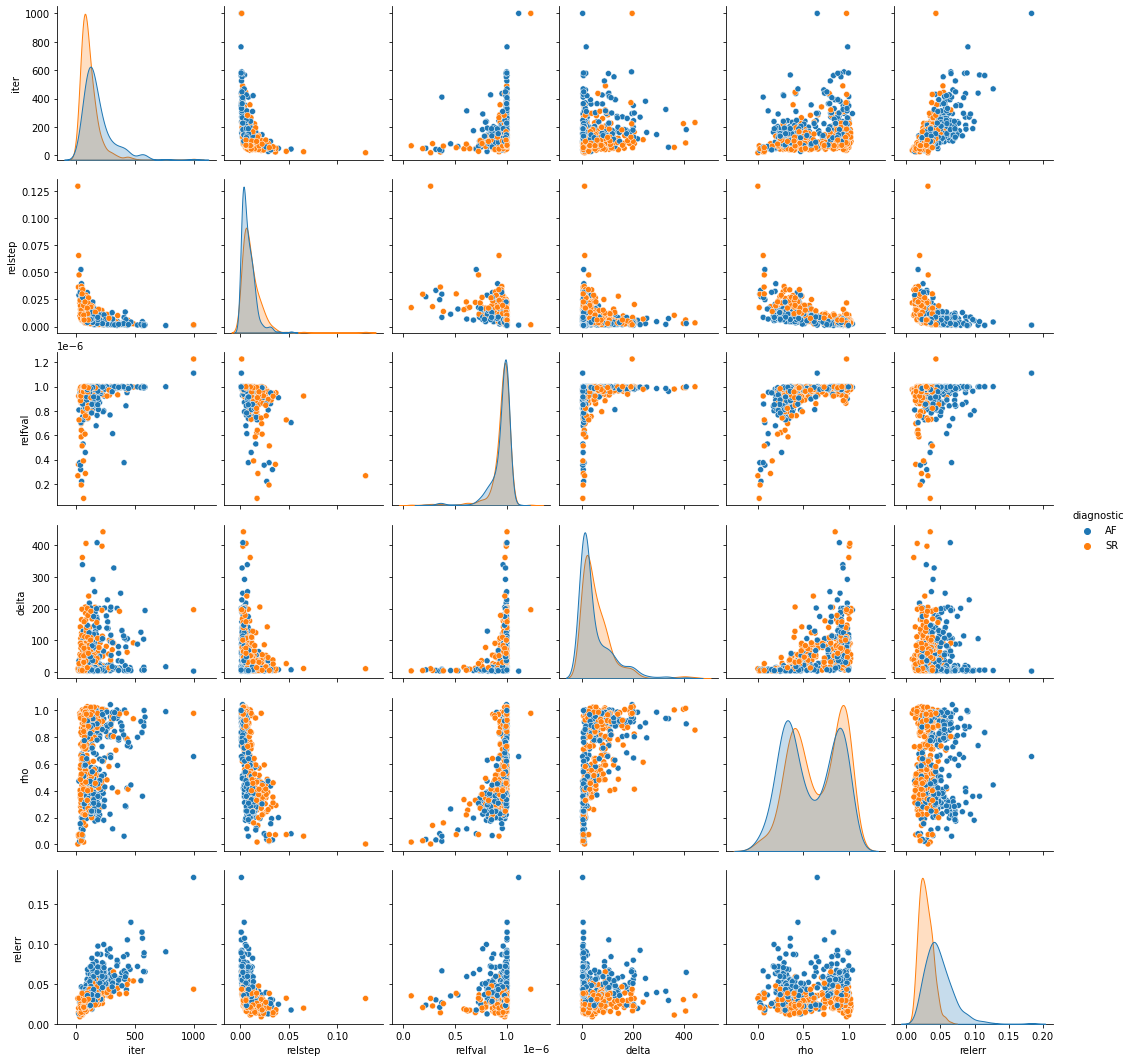

In [79]:
base_df = pd.read_csv('../workdata/shura/experiment3/results.csv')
base_df = base_df[base_df['db'] == 'WFDB_CPSC2018']

base_df = base_df.sample(frac=1).reset_index(drop=True)

base_df_af = base_df[base_df['diagnostic'] == 'AF']
base_df_sr = base_df[base_df['diagnostic'] == 'SR']
n_af = base_df_af.shape[0]
n_sr = base_df_sr.shape[0]
n = n_sr if n_af > n_sr else n_af

base_df = pd.concat([base_df_af[0:n], base_df_sr[0:n]], axis=0)
base_df = base_df.sample(frac=1).reset_index(drop=True)
base_df.groupby(['diagnostic', 'db']).size()
X_df = base_df[['iter', 'relstep', 'relfval', 'delta', 'rho', 'relerr']]
X = X_df.to_numpy()

Y_df = base_df[['diagnostic']]
Y = Y_df['diagnostic'].to_numpy()
le = preprocessing.LabelEncoder()
le.fit(Y)
Y = le.transform(Y)

bestfeatures = SelectKBest(score_func=chi2, k=X_df.shape[1])
fit = bestfeatures.fit(X, Y)
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X_df.columns)
feature_scores = pd.concat([df_columns, df_scores], axis=1)
feature_scores.columns = ['Specs', 'Score']
print(feature_scores)

corrmat = X_df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
sns.heatmap(X_df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

sns.pairplot(pd.concat([X_df, Y_df], axis=1), hue="diagnostic")

sc = StandardScaler()
X = sc.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=42)

### GridSearch

In [ ]:
parameter_space_mlp = {'hidden_layer_sizes': [(300, 40, 10), (300, 30), (300,)],
                       'activation': ['logistic', 'tanh', 'relu'],
                       'solver': ['sgd', 'adam'],
                       'alpha': [0.0001, 0.001, 0.005],
                       'learning_rate_init': [0.0001, 0.001, 0.01],
                       'max_iter': [200, 300, 400, 1000],
                       'early_stopping': [True, False],
                       'learning_rate': ['constant','adaptive']}

parameter_space_rf = {'bootstrap': [True],
                      'max_depth': [80, 90, 100, 110],
                      'max_features': [2, 3],
                      'min_samples_leaf': [3, 4, 5],
                      'min_samples_split': [8, 10, 12],
                      'n_estimators': [100, 200, 300, 1000]}

parameter_space_lda = {'solver': ['svd', 'lsqr', 'eigen'],
                       'shrinkage': ['auto', 0.01, 0.1, 1, None]}

parameter_space_svm = {'C': [0.1,1, 10, 100], 
                       'gamma': [1,0.1,0.01,0.001],
                       'kernel': ['rbf', 'poly', 'sigmoid']}


grid_mlp = GridSearchCV(MLPClassifier(), parameter_space_mlp, n_jobs=-1, cv=5)
grid_rf = GridSearchCV(RandomForestClassifier(), parameter_space, n_jobs=-1, cv=5)
grid_lda = GridSearchCV(LinearDiscriminantAnalysis(), parameter_space, n_jobs=-1, cv=5)
grid_svm = GridSearchCV(SVC(), parameter_space, n_jobs=-1, cv=5)

grid_mlp.fit(X, Y)
grid_rf.fit(X, Y)
grid_lda.fit(X, Y)
grid_svm.fit(X, Y)

print('Best parameters found:\n', grid_mlp.best_params_, grid_mlp.best_score_)
print('Best parameters found:\n', grid_rf.best_params_, grid_rf.best_score_)
print('Best parameters found:\n', grid_lda.best_params_, grid_lda.best_score_)
print('Best parameters found:\n', grid_svm.best_params_, grid_svm.best_score_)

# Classifier

/home/renan/Área de Trabalho/research-project/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/home/renan/Área de Trabalho/research-project/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/home/renan/Área de Trabalho/research-project/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/home/renan/Área de Trabalho/research-project/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Max

0.6942086648983201


/home/renan/Área de Trabalho/research-project/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


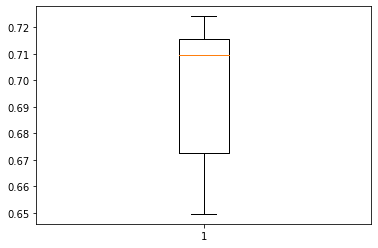

0.7439434129089302


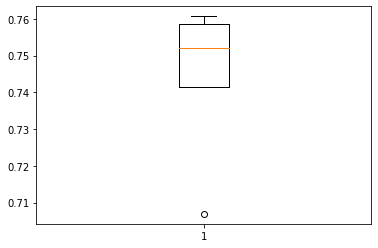

0.7490716180371353


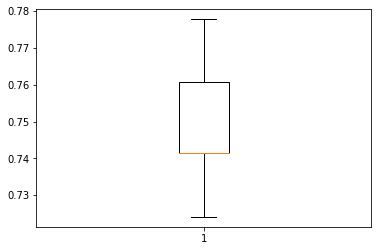

0.7473622163277336


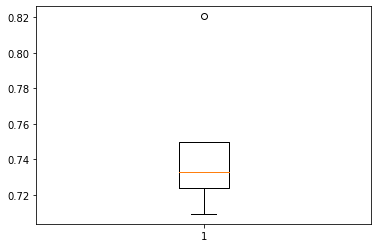

0.7061007957559682


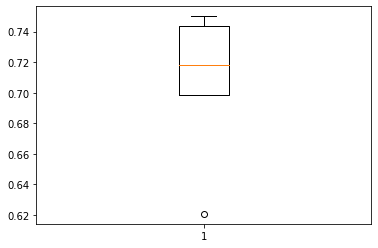

In [86]:
classifiers = {}

classifiers['svm'] = MLPClassifier(activation='tanh',
                                   alpha=0.005,
                                   early_stopping=False,
                                   hidden_layer_sizes=(300,30),
                                   learning_rate='adaptive',
                                   learning_rate_init=0.001,
                                   max_iter=1000,
                                   solver='adam')

classifiers['rf'] = RandomForestClassifier(bootstrap=True,
                                           max_depth=80,
                                           max_features=2,
                                           min_samples_leaf=5,
                                           min_samples_split=8,
                                           n_estimators=100)

classifiers['lda'] = LinearDiscriminantAnalysis(shrinkage=0.1, solver='lsqr')

classifiers['svc'] = SVC(C=0.1, gamma=1, kernel='poly')

classifiers['xgb'] = XGBClassifier()

kfold = model_selection.KFold(n_splits=5)
for alg, clf in classifiers.items():
    cv_results = model_selection.cross_val_score(clf, 
                                                 X, 
                                                 Y, 
                                                 cv=kfold, 
                                                 scoring='accuracy')
    print(f"{cv_results.mean()}")
    plt.boxplot(cv_results)
    plt.show()

In [106]:
X_train = np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = np.array(X_test).reshape(X_test.shape[0], X_test.shape[1], 1)
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=8, kernel_size=(6,), padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.001), input_shape = (X_train.shape[1],1)))
cnn_model.add(MaxPool1D(pool_size=(3,), strides=2, padding='same'))
cnn_model.add(Conv1D(filters=16, kernel_size=(6,), padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.001)))
cnn_model.add(MaxPool1D(pool_size=(3,), strides=2, padding='same'))
cnn_model.add(Flatten())
cnn_model.add(Dense(units = 300, activation=tf.keras.layers.LeakyReLU(alpha=0.001)))
cnn_model.add(Dense(units = 30, activation=tf.keras.layers.LeakyReLU(alpha=0.001)))
cnn_model.add(Dense(units = 2, activation='softmax'))
cnn_model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()
cnn_model_history = cnn_model.fit(X_train, y_train, epochs=10, batch_size=3, validation_data = (X_test, y_test))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 6, 8)              56        
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 3, 8)             0         
 g1D)                                                            
                                                                 
 conv1d_11 (Conv1D)          (None, 3, 16)             784       
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 2, 16)            0         
 g1D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 32)                0         
                                                                 
 dense_15 (Dense)            (None, 300)              

In [107]:
np.mean(cnn_model_history.history['val_accuracy'])

0.6728813648223877